# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('cat', 'dog', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
label1 = 3; label2 = 5 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = 0
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal rotations and shuffle new array
permutation = np.random.permutation(len(trainset.train_labels))
trainset.train_data = np.concatenate([trainset.train_data, 
                                      np.flip(trainset.train_data[permutation], axis=3).copy()], 0)
trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = 0
testset.test_labels[mask2] = 1

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Files already downloaded and verified
Data loaded:
- Training set size: 20000
- Test set size: 2000


In [2]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Test Images:


<Figure size 640x480 with 1 Axes>

  cat   cat   dog   dog   dog   dog   dog   dog
Train Images:


<Figure size 640x480 with 1 Axes>

  cat   dog   cat   dog   cat   cat   dog   cat


## Weak Learners: Neural Nets

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, architecture=1):
        super(Net, self).__init__()
        assert architecture in [0, 1, 2, 3]
        self.architecture = architecture
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        if self.architecture > 0: self.conv2 = nn.Conv2d(6, 16, 5)
        
        # fc for architecture 3
        if self.architecture == 3:
            self.fc3_1 = nn.Linear(16 * 5 * 5, 120)
            self.fc3_2 = nn.Linear(120, 84)
            self.fc3_3 = nn.Linear(84, 2)
        
        # fc for architecture 2
        if self.architecture == 2:
            self.fc2_1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2_2 = nn.Linear(120, 2)
        
        # fc for architecture 1
        if self.architecture == 1: self.fc1_1 = nn.Linear(16 * 5 * 5, 2)
        
        # fc for architecture 0
        if self.architecture == 0: self.fc0_1 = nn.Linear(6 * 14 * 14, 2)      
        
    
    def forward(self, x):
        
        # setup convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        if self.architecture > 0: 
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
        else:
            x = x.view(-1, 6 * 14 * 14)
            
        # setup fully connected layers
        if self.architecture == 0:
            x = self.fc0_1(x)
        elif self.architecture == 1:
            x = self.fc1_1(x)
        elif self.architecture == 2:
            x = F.relu(self.fc2_1(x))
            x = self.fc2_2(x)
        elif self.architecture == 3:
            x = F.relu(self.fc3_1(x))
            x = F.relu(self.fc3_2(x))
            x = self.fc3_3(x)
        else: raise("Incorrect model id input.")
            
        return x

In [4]:
# loss to use
criterion = nn.CrossEntropyLoss()   

# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    with torch.no_grad():
        net, _ = weak_learners[i]
        output = net(x)
        _, predict = torch.max(output.data, 1)
        predict = 2 * predict - 1 # map labels to -1, 1
        return predict

# update weak learner i
# accepts y in {0, 1}
def update_WL(weak_learners, x, y, i):
    net, optimizer = weak_learners[i]
    optimizer.zero_grad()
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    N = len(weak_learners)
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [5]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    net, optimizer = weak_learner
    for t, data in enumerate(trainloader, 1):        
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data        
        optimizer.zero_grad()
        output = net(x)        
        loss = criterion(output, y)
        _, predict = torch.max(output.data, 1)
        loss.backward()
        optimizer.step()
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time)

# Online BBM 

In [13]:
def onlineBBM(weak_learners, T):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    gamma = 0.05
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + (2*y-1) * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != (2*y-1)).item()
            
            # pass training example to WL j with some probability  
            prob = 1 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
                
        # evaluate mistakes
        n_mistakes += (y_hat != (2*y-1)).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
                
    return n_mistakes_over_time

# AdaBoost OL

In [7]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = (2 * y - 1) * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != (2*y-1)).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != (2*y-1)) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != (2*y-1)).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt

# plot variables
plt_interval = 50

# Enable GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available.")

GPU is available.


In [9]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        with torch.no_grad():
            for data in testloader:
                x, y = data
                y = 2 * y - 1
                prediction = predict_WL(weak_learners, x, i)
                correct += (prediction == y).sum().item()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    with torch.no_grad():
        for data in testloader: 
            x, y = data
            y = 2 * y - 1
            prediction = predict_WL_alg1(weak_learners, x)
            correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            x, y = data
            y = 2 * y - 1
            prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
            correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [10]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(architecture, T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    net = Net(architecture=architecture); print("Weak Learner architecture:\n", net)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    weak_learner = (net, optimizer)
    mistakes = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, architecture):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        net = Net(architecture=architecture)    
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        weak_learners.append((net, optimizer)) 
    print("Weak Learner architecture:\n", net) 
    
    # test
    mistakes = onlineBBM(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, architecture):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        net = Net(architecture=architecture)    
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        weak_learners.append((net, optimizer)) 
    print("Weak Learner architecture:\n", net)
        
    mistakes, alpha = adaboostOL(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Weak Learner architecture:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0_1): Linear(in_features=1176, out_features=2, bias=True)
)
Fraction of mistakes after 5000 iterations: 0.41
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 61 %


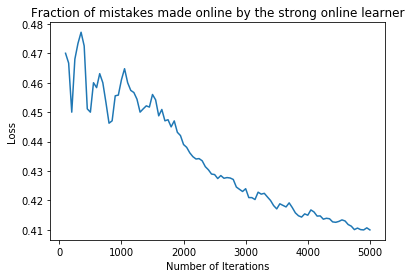

In [15]:
evaluate_baseline(architecture=0, T=5000)

## Online BBM

Evaluating Online BBM:

Weak Learner architecture:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc2_1): Linear(in_features=400, out_features=120, bias=True)
  (fc2_2): Linear(in_features=120, out_features=2, bias=True)
)
Fraction of mistakes by time 1000 0.466
Fraction of mistakes by time 2000 0.46
Fraction of mistakes by time 3000 0.451
Fraction of mistakes by time 4000 0.4345
Fraction of mistakes by time 5000 0.4284
Fraction of mistakes after 5000 iterations: 0.4284
Edges of weak learners:
 [0.0822 0.0684 0.0694 0.0638 0.0648 0.053  0.0232 0.0018 0.0206 0.0044]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 64 %
Accuracy of weak learner 1 on the 2000 test images: 61 %
Accuracy of weak learner 2 on the 2000 test images: 62 %
Accuracy of weak learner 3 on the 2000 test images: 60 %
Accuracy

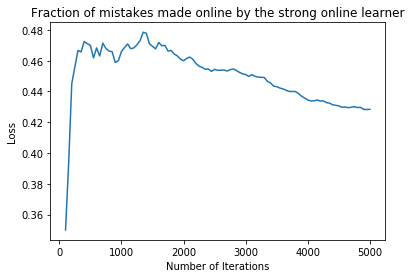

In [14]:
evaluate_onlineBBM(N=10, T=5000, architecture=2)

## Adaboost.OL

In [ ]:
evaluate_adaboostOL(N=5, T=20000, architecture=2)

## Run Experiments

In [21]:
def run_experiment(T=10000, N=10, net=0, model="bbm"):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, net)
    
# net architectures
# 0: 1c1f
# 1: 2c1f
# 2: 2c2f
# 3: 2c3f

In [ ]:
run_experiment(T=20000, N=5, net=0, model="adaboost")

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf